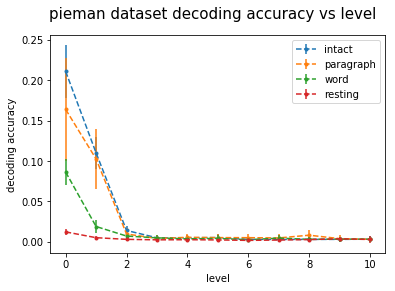

In [10]:
import matplotlib.pyplot as plt
import numpy as np
plt.suptitle("pieman dataset decoding accuracy vs level",fontsize=15)
plt.ylabel("decoding accuracy")
plt.xlabel("level")
data = np.load("../data/pieman-intact.npz")
y = data["arr_0"]
yerr = data["arr_1"]
plt.errorbar(range(11), y, yerr=yerr, fmt='--.', label = "intact")

data = np.load("../data/pieman-paragraph.npz")
y = data["arr_0"]
yerr = data["arr_1"]
plt.errorbar(range(11), y, yerr=yerr, fmt='--.', label = "paragraph")

data = np.load("../data/pieman-word.npz")
y = data["arr_0"]
yerr = data["arr_1"]
plt.errorbar(range(11), y, yerr=yerr, fmt='--.', label = "word")

data = np.load("../data/pieman-resting.npz")
y = data["arr_0"]
yerr = data["arr_1"]
plt.errorbar(range(11), y, yerr=yerr, fmt='--.', label = "resting")
plt.legend(bbox_to_anchor=(1, 1), loc=0)
plt.show()

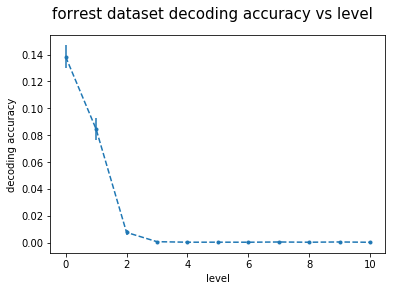

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.suptitle("forrest dataset decoding accuracy vs level",fontsize=15)
plt.ylabel("decoding accuracy")
plt.xlabel("level")
data = np.load("../data/forrest.npz")
y = data["arr_0"]
yerr = data["arr_1"]
plt.errorbar(range(11), y, yerr=yerr, fmt='--.')
plt.show()

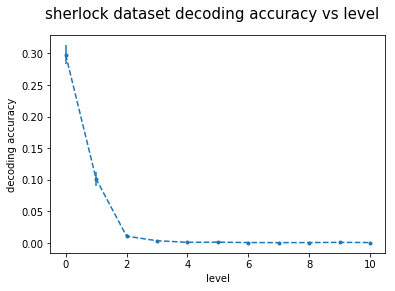

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.suptitle("sherlock dataset decoding accuracy vs level",fontsize=15)
plt.ylabel("decoding accuracy")
plt.xlabel("level")
data = np.load("../data/sherlock.npz")
y = data["arr_0"]
yerr = data["arr_1"]
plt.errorbar(range(11), y, yerr=yerr, fmt='--.')
plt.show()